In [1]:
# !pip install procgen

In [2]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive/')
# sys.path.append('/content/drive/My Drive/AIF')

In [3]:
import torch
from procgen import ProcgenEnv
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame
from agent import Agent
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

In [4]:
agent = Agent().to(DEVICE)
agent.load_state_dict(torch.load('agent_weights.pth'))
# agent.load_state_dict(torch.load('drive/MyDrive/AIF/agent_weights.pth'))
agent.eval()

Agent(
  (features): ImpalaModel(
    (block1): ImpalaBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res2): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (block2): ImpalaBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res1): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(

In [5]:
obs = env.reset()

while True:
    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    if done[0]:
        break

env.close()

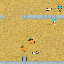

In [7]:

def obs_to_image(obs):
  return (obs[0].transpose(1,2,0) * 255).astype(np.uint8)

def display_trajectory(frames, fps=25):
  imageio.mimwrite('./tmp.gif',
                [obs_to_image(frame) for i, frame in enumerate(frames)],
                fps=fps)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))

frames = []
obs = env.reset()

while True:
    frames.append(obs)
    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

env.close()

display_trajectory(frames)